<a href="https://colab.research.google.com/github/Tiagofv/MLP/blob/main/MLP_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

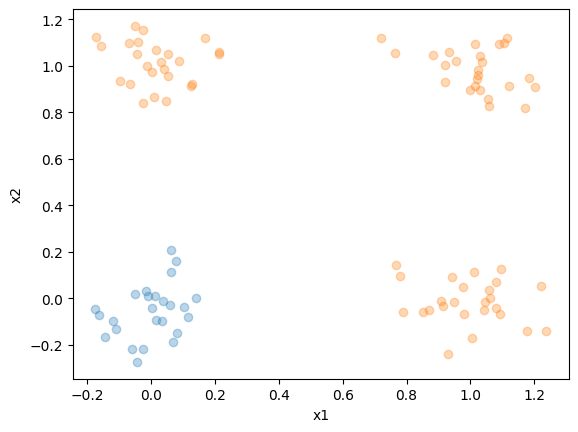

In [ ]:
def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = np.array(clf.predict(X)).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

def sign(a):
  return (a>0) * 1

def criaDataset(n=100, func=lambda a, b: bool(a) or bool(b)):
  X, y = make_blobs(n_samples=n, centers=[[0,0],[1,0],[1,1],[0,1]], cluster_std=0.1)
  y = sign(np.array([func(x[0]>0.5, x[1]>0.5) for x in X], dtype=int))
  return X, y

X, y = criaDataset()

def plotDataset(X, y):
  y_copy = y.copy()
  if y_copy.shape == (100, 1):
    y_copy = y_copy.reshape(100)

  plt.xlabel("x1")
  plt.ylabel("x2")
  for k in set(y_copy):
    plt.plot(X[:,0][y_copy==k],X[:,1][y_copy==k], "o", alpha=0.3)

plotDataset(X, y)

y = y.reshape(y.shape[0], -1) # format [[ 1],[ 1],...]

# Implementação MLP


In [ ]:

class MLP:
    """
    Implementation of a Multi-Layer Perceptron (MLP) neural network.

    Attributes:
        learning_rate (float): Learning rate.
        num_input (int): Number of input features.
        num_hidden (int): Number of hidden units.
        num_output (int): Number of output units.
        activation_function (function): Activation function used in the network.

    Methods:
        forward(X): Perform forward pass through the network.
        backward(X, y): Perform backward pass through the network for training.
        sigmoid(x, derivative=False): Sigmoid activation function.
        tanh(x, derivative=False): Hyperbolic tangent activation function.
        predict(X): Make predictions on input data.
        fit(X, y, num_epochs=1): Train the model on input-output pairs.
    """

    def __init__(self, learning_rate=0.1, num_input_features=2, num_hidden_units=2, num_output_units=1, activation_function=None):
        """
        Initialize the Multi-Layer Perceptron.

        Args:
            learning_rate (float): The learning rate for training.
            num_input_features (int): Number of features in the input layer.
            num_hidden_units (int): Number of units in the hidden layer.
            num_output_units (int): Number of units in the output layer.
            activation_function (function): Activation function for units.
        """
        self.learning_rate = learning_rate

        self.weights_input_hidden = np.random.uniform(size=(num_input_features, num_hidden_units))
        self.weights_hidden_output = np.random.uniform(size=(num_hidden_units, num_output_units))

        self.bias_input_hidden = np.random.uniform(size=(1, num_hidden_units))
        self.bias_hidden_output = np.random.uniform(size=(1, num_output_units))

        self.hidden_input = None
        self.hidden_output = None
        self.output_input = None
        self.output_output = None

        self.activation_function = activation_function

        if self.activation_function is None:
            self.activation_function = self.sigmoid

    def forward(self, input_data):
        """
        Perform forward pass through the network.

        Args:
            input_data (numpy.ndarray): Input data for prediction.

        Returns:
            numpy.ndarray: Predicted output.
        """
        self.hidden_input = np.dot(input_data, self.weights_input_hidden) + self.bias_input_hidden
        self.hidden_output = self.activation_function(self.hidden_input)
        self.output_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output
        self.output_output = self.activation_function(self.output_input)
        return self.output_output

    def backward(self, input_data, target_output):
        """
        Perform backward pass through the network for training.

        Args:
            input_data (numpy.ndarray): Input data for training.
            target_output (numpy.ndarray): Target output for training.
        """
        error = (target_output - self.output_output)
        d_output_final = error * self.activation_function(self.output_output, derivative=True)
        d_output = d_output_final * self.weights_hidden_output.T
        d_hidden_output = d_output * self.activation_function(self.hidden_output, derivative=True)
        grad_input_hidden = np.dot(input_data.T, d_hidden_output)
        grad_hidden_output = np.dot(self.hidden_output.T, d_output_final)
        self.weights_input_hidden += self.learning_rate * grad_input_hidden
        self.weights_hidden_output += self.learning_rate * grad_hidden_output
        self.bias_input_hidden += np.sum(self.learning_rate * d_hidden_output, axis=0)
        self.bias_hidden_output += np.sum(self.learning_rate * d_output_final, axis=0)

    def sigmoid(self, x, derivative=False):
        """
        Sigmoid activation function.

        Args:
            x (numpy.ndarray): Input data.
            derivative (bool): If True, return derivative of the sigmoid function.

        Returns:
            numpy.ndarray: Sigmoid function or its derivative.
        """
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def tanh(self, x, derivative=False):
        """
        Hyperbolic tangent activation function.

        Args:
            x (numpy.ndarray): Input data.
            derivative (bool): If True, return derivative of the tanh function.

        Returns:
            numpy.ndarray: Tanh function or its derivative.
        """
        if derivative:
            y = self.tanh(x)
            return 1 - y**2
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    def predict(self, input_data):
        """
        Make predictions on input data.

        Args:
            input_data (numpy.ndarray): Input data for prediction.

        Returns:
            list: Predictions for each input sample.
        """
        predictions = []
        for data_point in input_data:
            data_point = np.transpose(data_point)
            if self.forward(data_point) >= 0.5:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions

    def fit(self, input_data, target_output, num_epochs=1):
        """
        Train the model on input-output pairs.

        Args:
            input_data (numpy.ndarray): Input data for training.
            target_output (numpy.ndarray): Target output for training.
            num_epochs (int): Number of epochs for training.
        """
        for _ in range(num_epochs):
            self.forward(input_data)
            self.backward(input_data, target_output)



In [ ]:
init = MLP()

def plot_and_predict(activation_fn):
  mlp = MLP(num_input_features=X.shape[1], num_hidden_units=8, num_output_units=1, activation_function=activation_fn)
  X_copy = X.copy()
  mlp.fit(X_copy, y, num_epochs=1000)

  y_pred = mlp.predict(X_copy)

  plotDataset(X,y)
  plotPredictions(mlp, X)

  return y_pred



## Sigmoid

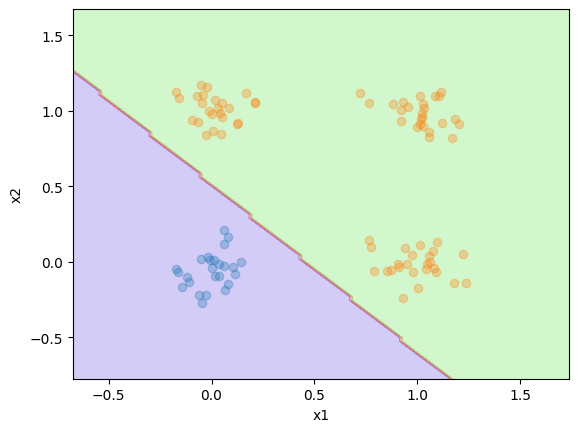

In [ ]:
y_sigmoid = plot_and_predict(init.sigmoid)

## Tanh

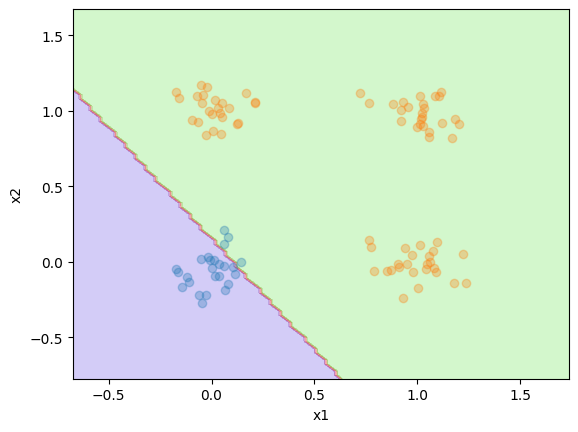

In [ ]:
y_tanh = plot_and_predict(init.tanh)


# Metrics
  

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Using Sigmoid
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        75

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Using Tanh
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        25
           1       0.95      1.00      0.97        75

    accuracy                           0.96       100
   macro avg       0.97      0.92      0.94       100
weighted avg       0.96      0.96      0.96       100



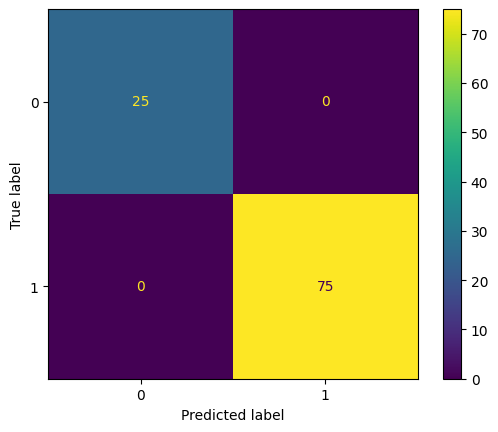

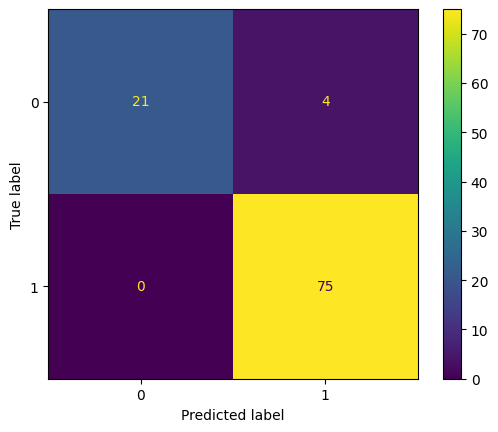

In [ ]:
def get_metrics(y, y_pred):
  print(classification_report(y, y_pred))
  cm = confusion_matrix(y, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.plot()

print("Using Sigmoid")
get_metrics(y, y_sigmoid)
print("Using Tanh")
get_metrics(y, y_tanh)

# Implementação Scikit learn

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier()

mlp_clf.fit(X, y )

y_pred = mlp_clf.predict(X)
y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


array([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1])

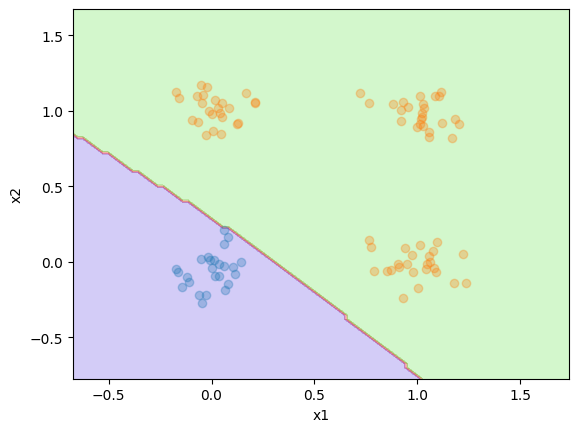

In [ ]:
plotDataset(X,y)
plotPredictions(mlp_clf, X)

## Metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        75

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



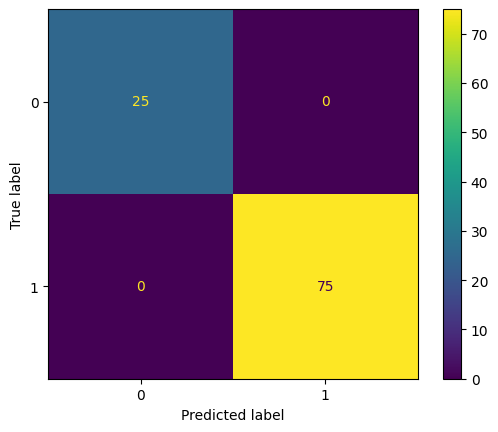

In [ ]:
get_metrics(y, y_pred)

# Conclusão
Neste estudo, observamos que a função Sigmóide, quando empregada como função de ativação na implementação proposta, geralmente resultou em maior acurácia em comparação com a função tangente hiperbólica, especialmente quando consideramos apenas 100 épocas de treinamento.

Ao comparar nossa implementação com a implementação da biblioteca scikit-learn para o conjunto de dados em questão, podemos constatar que ambas as abordagens foram capazes de resolver o problema sem erros em todos os casos analisados. Isso sugere que nossa implementação conseguiu alcançar resultados comparáveis aos obtidos com uma biblioteca amplamente utilizada e validada como o scikit-learn (Para o dataset proposto).
